# Muon From Scratch

git: [xiaodongguaAIGC](https://github.com/dhcode-cpp)

In [1]:
import torch
torch.manual_seed(42)

## Muon 算法


[Muon优化器赏析：从向量到矩阵的本质跨越](https://kexue.fm/archives/10592)

\begin{equation}\begin{aligned} 
\boldsymbol{M}_t =&\, \beta\boldsymbol{M}_{t-1} + \boldsymbol{G}_t \\[5pt] 
\boldsymbol{W}_t =&\, \boldsymbol{W}_{t-1} - \eta_t [\text{msign}(\boldsymbol{M}_t) + \lambda \boldsymbol{W}_{t-1}] \\ 
\end{aligned}\end{equation}

- 动量 + 梯度
- msign 是一种什么样的变换（见底部有图）
- msign 满足什么约束

## msign()

In [2]:
n = 2
m = 3
M = torch.randn(n, m)
print(M)

tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863]])


msign 计算较麻烦，特别是求矩阵幂


\begin{equation}\text{msign}(\boldsymbol{M}) = (\boldsymbol{M}\boldsymbol{M}^{\top})^{-1/2}\boldsymbol{M}= \boldsymbol{M}(\boldsymbol{M}^{\top}\boldsymbol{M})^{-1/2}\end{equation}


### sign()

$\text{sign}(x)=x(x^2)^{-1/2}$ 即是符号函数

In [3]:
def sign(x):  # x 为标量
    """
    求符号事实上可以求 x > 0 来判别,
    以下计算不用条件符号进行判别，会增加一定的计算量。
    """
    return x * (x**2) ** (-1/2)


print(sign(-1))
print(sign(2.3))

-1.0
1.0


In [4]:
print(sign(M))

tensor([[ 1.0000,  1.0000,  1.0000],
        [ 1.0000, -1.0000, -1.0000]])


### msign

msign 公式是建立在矩阵上，与逐个元素 sign 函数处理并不一样。

但是 torch 的 `matrix_power` 方法的 参数`n` 要求是整型变量

| 需求      | 正确方法                         |
| ------- | ---------------------------- |
| 矩阵乘法幂运算 | `torch.matrix_power(A, n)`   |
| 逐元素幂运算  | `A ** n` 或 `torch.pow(A, n)` |

In [5]:
msign_M = M @ torch.matrix_power(M.t() @ M, -1/2)  # -1/2 非整数
print(msign_M)

# 注意：此代码会报错，跳过，继续往下执行

TypeError: matrix_power(): argument 'n' (position 2) must be int, not float

In [6]:
def matrix_inv_sqrt_svd(M, eps=1e-10):
    """
    M: (..., n, n) 任意实方阵（支持批维度）
    返回: M^{-1/2} 同形状
    """
    U, S, V = torch.linalg.svd(M, full_matrices=False)   # M = U @ diag(S) @ V
    inv_sqrt_S = torch.diag_embed(1.0 / torch.sqrt(S + eps))  # Σ^{-1/2}
    return U @ inv_sqrt_S @ V                            # V Σ^{-1/2} U^T


msign_M = M @ matrix_inv_sqrt_svd(M.t() @ M)
print(msign_M)
msign_M = matrix_inv_sqrt_svd(M @ M.t()) @ M
print(msign_M)

tensor([[ 0.8342,  0.1452,  0.5317],
        [ 0.2494, -0.9598, -0.1288]])
tensor([[ 0.8346,  0.1453,  0.5314],
        [ 0.2491, -0.9599, -0.1287]])


In [7]:
# 特例: M = 1 x 1
tmp = torch.ones(1, 1) * 2.3
msign_tmp = tmp @ matrix_inv_sqrt_svd(tmp.t() @ tmp)
print(msign_tmp)

tmp = torch.ones(1, 1) * -0.01
msign_tmp = tmp @ matrix_inv_sqrt_svd(tmp.t() @ tmp)
print(msign_tmp)

tensor([[1.]])
tensor([[-1.0000]])


当 $m \in \mathbb{R} ^ {n \times 1}$ 时:
$$ 
\text{msign}(\boldsymbol{m}) = \boldsymbol{m}/\Vert\boldsymbol{m}\Vert_2
$$

In [8]:
# 特例: M = n x 1
vec = torch.randn(3, 1)
msign_vec = vec @ matrix_inv_sqrt_svd(vec.t() @ vec)
print(vec)
print(msign_vec)

vec_norm = vec / torch.norm(vec)
print(vec_norm)

tensor([[ 2.2082],
        [-0.6380],
        [ 0.4617]])
tensor([[ 0.9419],
        [-0.2721],
        [ 0.1969]])
tensor([[ 0.9419],
        [-0.2721],
        [ 0.1969]])


$\text{msign}(\boldsymbol{M})$ “最优正交近似“，求最优化：

$$\text{msign}(\boldsymbol{M}) = \mathop{\text{argmin}}_{\boldsymbol{O}^{\top}\boldsymbol{O} = \boldsymbol{I}}\Vert \boldsymbol{M} - \boldsymbol{O}\Vert_F^2$$

求解：

\begin{equation}\begin{aligned} 
\Vert \boldsymbol{M} - \boldsymbol{O}\Vert_F^2 =&\,  \Vert \boldsymbol{M}\Vert_F^2 + \Vert \boldsymbol{O}\Vert_F^2 - 2\langle\boldsymbol{M},\boldsymbol{O}\rangle_F \\[5pt] 
=&\,  \Vert \boldsymbol{M}\Vert_F^2 + n - 2\text{Tr}(\boldsymbol{M}\boldsymbol{O}^{\top})\\[5pt] 
=&\,  \Vert \boldsymbol{M}\Vert_F^2 + n - 2\text{Tr}(\boldsymbol{U}\boldsymbol{\Sigma}\boldsymbol{V}^{\top}\boldsymbol{O}^{\top})\\[5pt] 
=&\,  \Vert \boldsymbol{M}\Vert_F^2 + n - 2\text{Tr}(\boldsymbol{\Sigma}\boldsymbol{V}^{\top}\boldsymbol{O}^{\top}\boldsymbol{U})\\ 
=&\,  \Vert \boldsymbol{M}\Vert_F^2 + n - 2\sum_{i=1}^n \boldsymbol{\Sigma}_{i,i}(\boldsymbol{V}^{\top}\boldsymbol{O}^{\top}\boldsymbol{U})_{i,i} 
\end{aligned}\end{equation}


当 $\boldsymbol{O}=\boldsymbol{U}\boldsymbol{V}^{\top} $ 时，$(\boldsymbol{V}^{\top}\boldsymbol{O}^{\top}\boldsymbol{U})_{i,i}$最大， 上式目标最小。

In [9]:
# 最优情况
U, S, V = torch.linalg.svd(M, full_matrices=False)
O = U @ V
m_sub_o = torch.norm(M - O) ** 2
print(m_sub_o)

tensor(0.3666)


In [10]:
# 非最优
O_sub_optimal = U[:, :1] @ V[:1, :]  # 最优情况
m_sub_o = torch.norm(M - O_sub_optimal) ** 2
print(m_sub_o)

tensor(0.2020)


In [11]:
print(V @ O.t() @ U)
print(O @ O.t())  # 上式 maybe 有错误

tensor([[ 1.0000e+00, -5.2018e-09],
        [-3.2838e-09,  1.0000e+00]])
tensor([[ 1.0000e+00, -1.2180e-08],
        [-1.2180e-08,  1.0000e+00]])


In [12]:
print(O)
print(msign_M)

tensor([[ 0.8346,  0.1453,  0.5314],
        [ 0.2491, -0.9599, -0.1287]])
tensor([[ 0.8346,  0.1453,  0.5314],
        [ 0.2491, -0.9599, -0.1287]])


理论上 msign_M = U @ V

### 用 SVD 证明恒等式

\begin{align}
\text{msign}(\boldsymbol{M}) &= (\boldsymbol{M}\boldsymbol{M}^{\top})^{-1/2}\boldsymbol{M} \\
&= (U\Sigma V^\top V (\Sigma)^{-1} U^\top) ^ {-1/2} U\Sigma V^\top \\
& = (U\Sigma I (\Sigma)^{-1} U^\top) ^ {-1/2} U\Sigma V^\top \\
& =  UI^{-1/2}U^\top U\Sigma V^\top \\
& =  U \Sigma^{-1/2} V^\top
\end{align}

In [13]:
print(V @ V.t())  # -> I
print(U @ V)
print(U.t() @ U)  # -> I

tensor([[ 1.0000e+00, -2.3060e-08],
        [-2.3060e-08,  1.0000e+00]])
tensor([[ 0.8346,  0.1453,  0.5314],
        [ 0.2491, -0.9599, -0.1287]])
tensor([[1.0000e+00, 1.9002e-08],
        [1.9002e-08, 1.0000e+00]])


超大型的 SVD 矩阵求解复杂度高，

prompt: 分析一个超大型的 矩阵的 SVD 分解的复杂度

得到答案在 O(nm²) , 当$m\approx n$ O(m^3) 

K2 参数量分析

- `"hidden_size": 7168,` # embd size
- `"intermediate_size": 18432,`
  
即
- ffn w_up ( 7168 x 18432 )
- attn w_q ( 7168 x 7168 )

## Newton-schulz 求解 msign

对标量 $t^{-1/2}$ 进行泰勒展开

$$
\begin{equation}t^{-1/2} = 1 - \frac{1}{2}(t-1) + \frac{3}{8}(t-1)^2 - \frac{5}{16}(t-1)^3 + \cdots\end{equation}
$$

以下代码可见随展开阶数增加，越接近真值

In [14]:
t = 1.2
print(t ** (-1/2))
t_order_1 = 1 - 1/2 * (t-1)
t_order_2 = 1 - 1/2 * (t-1) + 3/8 * (t-1)**2
t_order_3 = 1 - 1/2 * (t-1) + 3/8 * (t-1)**2 - 5/16 * (t-1)**3
print(t_order_1)
print(t_order_2)
print(t_order_3)

0.9128709291752769
0.9
0.915
0.9125000000000001


对 msign 同理做 矩阵的 泰勒展开, 保留2阶 $(15 - 10t + 3t^2)/8$ :
$$
\begin{equation}\text{msign}(\boldsymbol{M}) = \boldsymbol{M}(\boldsymbol{M}^{\top}\boldsymbol{M})^{-1/2}\approx \frac{15}{8}\boldsymbol{M} - \frac{5}{4}\boldsymbol{M}(\boldsymbol{M}^{\top}\boldsymbol{M}) + \frac{3}{8}\boldsymbol{M}(\boldsymbol{M}^{\top}\boldsymbol{M})^2\end{equation}
$$
同理写出代码

In [15]:
print(msign_M)
A = M.t() @ M
msign_M_order_1 = 15/8 * M
msign_M_order_2 = 15/8 * M - 5/4 * M @ (A)
msign_M_order_3 = 15/8 * M - 5/4 * M @ (A) + 3/8 * M @ torch.matrix_power(A, 2)
print('order-1: \n', msign_M_order_1)
print('order-2: \n', msign_M_order_2)
print('order-3: \n', msign_M_order_3)

tensor([[ 0.8346,  0.1453,  0.5314],
        [ 0.2491, -0.9599, -0.1287]])
order-1: 
 tensor([[ 0.6313,  0.2415,  0.4396],
        [ 0.4319, -2.1054, -0.3494]])
order-2: 
 tensor([[ 0.5854,  0.0563,  0.3596],
        [ 0.0902, -0.1947, -0.0028]])
order-3: 
 tensor([[ 0.5766,  0.1300,  0.3756],
        [ 0.2269, -0.9739, -0.1457]])


## 迭代求解 msign

$$
\begin{equation}\boldsymbol{X}_{t+1} = \frac{15}{8}\boldsymbol{X}_t - \frac{5}{4}\boldsymbol{X}_t(\boldsymbol{X}_t^{\top}\boldsymbol{X}_t) + \frac{3}{8}\boldsymbol{X}_t(\boldsymbol{X}_t^{\top}\boldsymbol{X}_t)^2\end{equation}
$$
其中 $\boldsymbol{X}_t=\text{msign}(\boldsymbol{M})$

In [16]:
M_old = M

for i in range(5):
    A = M_old.t() @ M_old
    M_new = 15/8 * M_old - 5/4 * M_old @ (A) + 3/8 * M_old @ torch.matrix_power(A, 2)
    print((M_new-msign_M).norm())
    M_old = M_new
print(M_old)

tensor(0.3034)
tensor(0.0548)
tensor(0.0004)
tensor(2.1179e-07)
tensor(3.1328e-07)
tensor([[ 0.8346,  0.1453,  0.5314],
        [ 0.2491, -0.9599, -0.1287]])


## Muon 官方参数

以上近似效果差，尝试用 Muon 实现用的系数 $(3.4445, -4.7750,  2.0315)$

In [17]:
print(msign_M)
A = M.t() @ M
# (3.4445, -4.7750,  2.0315)
msign_M_muon = 3.4445 * M - 4.7750 * \
    M @ (A) + 2.0315 * M @ torch.matrix_power(A, 2)
print('order-3-muon: \n', msign_M_muon)

tensor([[ 0.8346,  0.1453,  0.5314],
        [ 0.2491, -0.9599, -0.1287]])
order-3-muon: 
 tensor([[ 0.9366,  0.1357,  0.5884],
        [ 0.2288, -0.7899, -0.0919]])


In [18]:
# 迭代形式
M_old = M

for i in range(5):
    A = M_old.t() @ M_old
    M_new = 3.4445 * M_old - 4.7750 * M_old @ (A) + 2.0315 * M_old @ torch.matrix_power(A, 2)
    print((M_new-msign_M).norm())
    M_old = M_new

tensor(0.2107)
tensor(0.2823)
tensor(0.2492)
tensor(0.3085)
tensor(0.3375)


本代码示例可能由于矩阵较小，标准泰勒展开更佳，而 Muon 官方参数收敛效果不如 泰勒系数。

## 迭代参数求解
效果较好，接下来求解魔法数字。

\begin{equation}\boldsymbol{X}_{t+1} = a\boldsymbol{X}_t + b\boldsymbol{X}_t(\boldsymbol{X}_t^{\top}\boldsymbol{X}_t) + c\boldsymbol{X}_t(\boldsymbol{X}_t^{\top}\boldsymbol{X}_t)^2\end{equation}

经 SVD 分解：

\begin{equation}\boldsymbol{X}_{t+1} = \boldsymbol{U}_{[:,:r]}(a \boldsymbol{\Sigma}_{t,[:r,:r]} + b \boldsymbol{\Sigma}_{t,[:r,:r]}^3 + c \boldsymbol{\Sigma}_{t,[:r,:r]}^5)\boldsymbol{V}_{[:,:r]}^{\top}\end{equation}

化为求 $g(x) = ax + bx^3 + cx^5$, 需要将 $\Sigma$ 变为单位阵，将$g(x)$ 重参数化

\begin{equation}g(x) = x + \kappa x(x^2 - x_1^2)(x^2 - x_2^2)\end{equation}

“可以采样一批矩阵，并通过 SVD 来算奇异值”

In [19]:
# 注意：如果要跑迭代，则取消注释

# # 该代码运行时长较旧，可以适当跳过
# # 以下代码由 Deepseek-V3 转化：
# from tqdm import tqdm

# n, m, T = 1024, 1024, 5
# data = torch.tensor([])
# for _ in tqdm(range(1000), ncols=0, desc='SVD'):
#     X = torch.randn(n, m)
#     U, S, V = torch.linalg.svd(X, full_matrices=False)
#     normalized_S = S / (S**2).sum()**0.5 # M / M^2 ** -1/2
#     data = torch.cat([data, normalized_S])

# def f(w, x):
#     k, x1, x2 = w
#     for _ in range(T):
#         x = x + k * x * (x**2 - x1**2) * (x**2 - x2**2)
#     return ((x - 1)**2).mean() # MSE Loss

# w = torch.tensor([1.0, 0.9, 1.1], requires_grad=True) # 求解参数
# u = torch.zeros(3)

# optimizer = torch.optim.SGD([w], lr=0.01, momentum=0.9)

# for _ in tqdm(range(100000), ncols=0, desc='SGD'):
#     optimizer.zero_grad()
#     loss = f(w, data)
#     loss.backward()
#     optimizer.step()

# k, x1, x2 = w.detach()
# a, b, c = 1 + k * x1**2 * x2**2, -k * (x1**2 + x2**2), k
# print(f'{n} & {m} & {T} & {k:.3f} & {x1:.3f} & {x2:.3f} & {a:.3f} & {b:.3f} & {c:.3f} & {f(w, data):.5f}')

# result
# SVD: 100% 1000/1000 [03:01<00:00,  5.52it/s]
# SGD: 100% 100000/100000 [30:37<00:00, 54.42it/s]
# 1024 & 1024 & 5 & 1.724 & 0.935 & 1.235 & 3.297 & -4.136 & 1.724 & 0.02733

In [20]:
print(msign_M)
M = torch.tensor([[0.3367,  0.1288,  0.2345],
                  [0.2303, -1.1229, -0.1863]])
A = M.t() @ M
# (3.4445, -4.7750,  2.0315)
msign_M_muon_iteration = 3.297 * M - 4.136 * \
    M @ (A) + 1.724 * M @ torch.matrix_power(A, 2)
print('order-3-muon: \n', msign_M_muon)
print('msign_M_muon_iteration: \n', msign_M_muon_iteration)

tensor([[ 0.8346,  0.1453,  0.5314],
        [ 0.2491, -0.9599, -0.1287]])
order-3-muon: 
 tensor([[ 0.9366,  0.1357,  0.5884],
        [ 0.2288, -0.7899, -0.0919]])
msign_M_muon_iteration: 
 tensor([[ 0.9176,  0.1509,  0.5818],
        [ 0.2574, -0.9622, -0.1244]])


In [21]:
# 迭代求解
M_old = M

for i in range(5):
    A = M_old.t() @ M_old
    M_new = 3.297 * M_old - 4.136 * M_old @ (A) + 1.724 * M_old @ torch.matrix_power(A, 2)
    print((M_new-msign_M).norm())
    M_old = M_new

tensor(0.0977)
tensor(0.1560)
tensor(0.0281)
tensor(0.1474)
tensor(0.0365)


## 分析

引用su：

- Muon比Adam少一组缓存变量，显存成本更低。
- 但个人观点，Adam之类的Element-wise的优化器肯定会有瓶颈的，所以随着研究的深入，肯定会有越来越多的优化器需要加入total grad的信息来提升性能，所以Muon需要total grad来运算这一特性，工程上早晚都是需要接受的。
- Muon相当于2范数约束下的梯度下降

重新 review muon 算法

1. msign 相当于将 动量M+梯度G 的更新矩阵进行约束
2. msign 忽略缩放杂质，仅逼近低秩正交量 U[m,:r] @ V[:r,n]

## msign 几何意义

In [22]:
n = 1
A = torch.randn(n, 3, 3)
matrixs = []
for i in range(n):
    U, S, V = torch.linalg.svd(A[i, :, :], full_matrices=False)
    B = U @ V  # msign
    matrixs.append(A[i, :, :])
    matrixs.append(B)

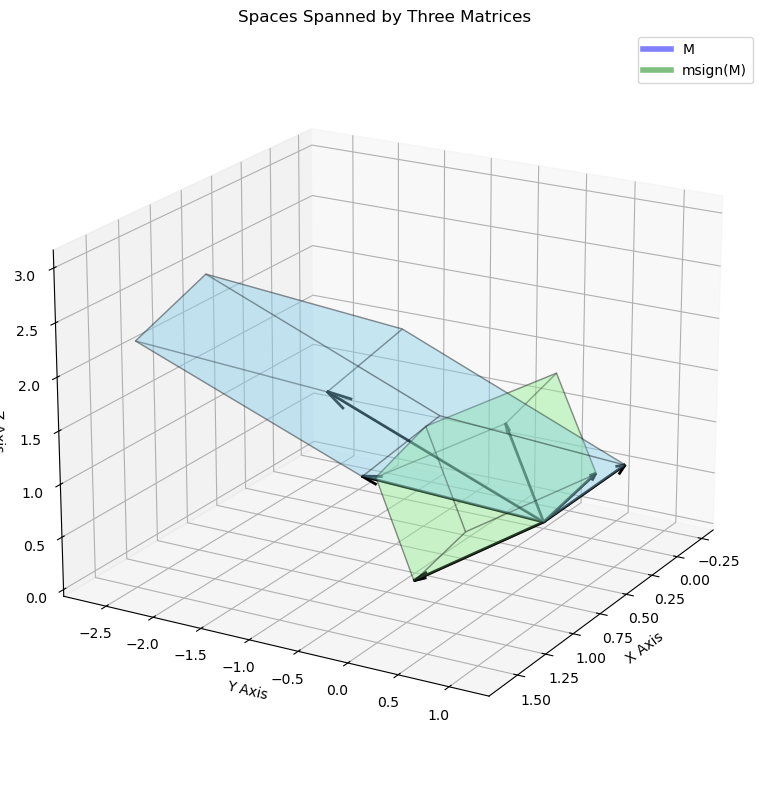

In [23]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# 创建图形和3D坐标轴
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 生成平行六面体的顶点


def generate_parallelepiped(vectors):
    # 顶点列表 (8个顶点)
    vertices = torch.zeros(8, 3)
    # 生成所有顶点组合
    for i, (a, b, c) in enumerate([(x, y, z) for x in [0, 1] for y in [0, 1] for z in [0, 1]]):
        vertices[i] = a * vectors[:, 0] + b * vectors[:, 1] + c * vectors[:, 2]
    return vertices


# 定义平行六面体的面 (6个面)
faces = [
    [0, 1, 3, 2],  # 底面
    [4, 5, 7, 6],  # 顶面
    [0, 1, 5, 4],  # 前面
    [2, 3, 7, 6],  # 后面
    [0, 2, 6, 4],  # 左面
    [1, 3, 7, 5]   # 右面
]

# 绘制三个平行六面体
colors = ['skyblue', 'lightgreen']
labels = ['M', 'msign(M)', ]

for idx, matrix in enumerate(matrixs):
    # 生成顶点
    vertices = generate_parallelepiped(matrix)

    # 绘制边
    for face in faces:
        x = [vertices[i][0] for i in face]
        y = [vertices[i][1] for i in face]
        z = [vertices[i][2] for i in face]
        poly = Poly3DCollection([list(zip(x, y, z))],
                                alpha=0.25, edgecolor='black')
        poly.set_facecolor(colors[idx % 2])
        ax.add_collection3d(poly)

    # 绘制向量箭头
    for i in range(3):
        ax.quiver(0, 0, 0,
                  matrix[0, i], matrix[1, i], matrix[2, i],
                  color='black', lw=2, arrow_length_ratio=0.1)

# 设置坐标轴标签
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# 设置标题和图例
plt.title('Spaces Spanned by Three Matrices')
ax.legend(handles=[
    plt.Line2D([0], [0], color='blue', lw=4, alpha=0.5, label=labels[0]),
    plt.Line2D([0], [0], color='green', lw=4, alpha=0.5, label=labels[1]),
])

# 调整视角以便更好地观察
ax.view_init(elev=20, azim=30)

# 显示图形
plt.tight_layout()
plt.show()

# Reference

[Muon优化器赏析：从向量到矩阵的本质跨越](https://kexue.fm/archives/10592)